In [1]:
import random
import numpy as np

SEED = 93
np.random.seed(SEED)
random.seed(SEED)

In [2]:
import torch

if torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cuda')

# Yelp Sentiment Model Classifier Only

The goal of this notebook is to train a logit classifier on the Yelp Review dataset that sits on top of the Distilled Bert Model (uncased).

Note that for all of the parameters in the base model, they are set to be frozen. Thus, only the added classifier layers are trained via SGD.

In [3]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

id2label = {0: "Negative", 1: "Positive"}
label2id = {v: k for k, v in id2label.items()}

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=len(id2label), id2label=id2label, label2id=label2id
).to(device)

for param in model.base_model.parameters():
    param.requires_grad = False

model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

## Balancing Dataset

The model is first trained using the balanced dataset curated in the YelpSentimentData notebook. Then, it is evaluatd on a test and evaluation set with the unbalanced label distribution that should be close to the distribution of the raw data.

In [4]:
from datasets import load_dataset

data_dict = {
    "train": "yelp_train_balanced.parquet",
    "eval": "yelp_eval.parquet",
    "test": "yelp_test.parquet"
}

yelp_batrain_data = load_dataset("parquet", data_files=data_dict, split="train")
yelp_eval_data = load_dataset("parquet", data_files=data_dict, split="eval")
yelp_batrain_data = yelp_batrain_data.filter(lambda x: x["label"] != 3)
yelp_eval_data = yelp_eval_data.filter(lambda x: x["label"] != 3)
yelp_batrain_data

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 217928
})

Prior to running the optimizer, the raw texts are tokenized, and the ratings are re-labeled into positive and negatives. In this case, a rating of >= 4 is considered to be positive, while a rating of <= 2 is considered to be negative. The middle cases are discarded since they are controversal.

In [5]:
from transformers import DataCollatorWithPadding, AutoTokenizer
from common import tokenize_and_label

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

yelp_batrain_data = yelp_batrain_data.map(lambda x: tokenize_and_label(tokenizer, x), 
                                          batched=True)
yelp_eval_data = yelp_eval_data.map(lambda x: tokenize_and_label(tokenizer, x), 
                                    batched=True)
yelp_eval_data["label"][:5]

[1, 0, 1, 0, 1]

The training is done with a learning rate of 0.0001 over 4 epochs with a weight decay weight of 0.01 according to the parameters given in the BERT paper. 

In [6]:
from common import compute_accuracy

BATCH_TRAIN = 128
BATCH_EVAL = 256
GRADIENT_STEP = 1
LEARNING_RATE = 1e-4
EPOCHS = 4
LAMBDA = 0.01

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="yelp-distil-bert-sbal",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_TRAIN,
    per_device_eval_batch_size=BATCH_EVAL,
    gradient_accumulation_steps=GRADIENT_STEP,
    gradient_checkpointing=False,
    num_train_epochs=EPOCHS,
    weight_decay=LAMBDA,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    seed=SEED
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=yelp_batrain_data,
    eval_dataset=yelp_eval_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_accuracy
)

try:
    results = trainer.train(resume_from_checkpoint = True)
except ValueError as e:
    results = trainer.train(resume_from_checkpoint = False)

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Balanced Accuracy,Roc Auc,Kappa,F1
1,0.188100,0.255383,0.905440,0.905440,0.791098,0.905173
2,0.183900,0.271449,0.900557,0.900557,0.778235,0.897724
3,0.177200,0.221098,0.917814,0.917814,0.821925,0.921539
4,0.174300,0.244344,0.910286,0.910286,0.801933,0.910659


The cross entropy loss is shown below. The epoch with the lowest eval loss is loaded in the end.

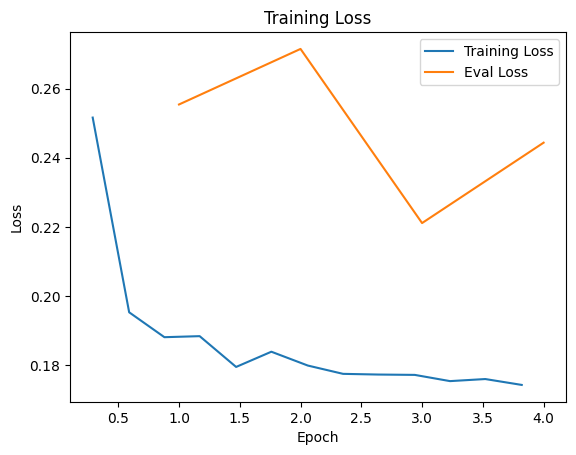

In [7]:
from common import plot_training

plot_training(trainer)

Some metrics of actual concerns on the evaluation set are given below. Overall, the cross entropy loss matched with the other metrics.

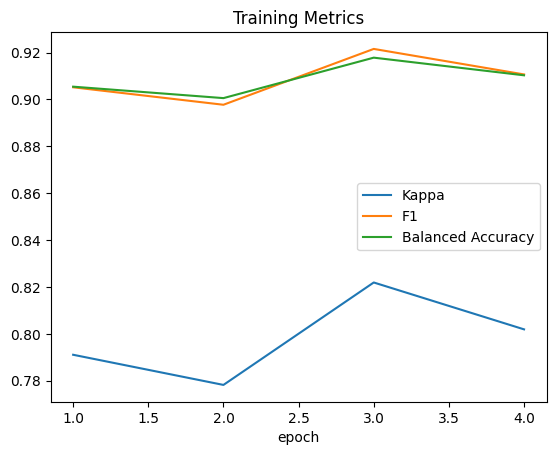

In [8]:
from common import plot_eval

plot_eval(trainer)

A test set is loaded and preprocessed similar to the training/eval set.

In [9]:
from common import test_inference

yelp_test = load_dataset("parquet", data_files=data_dict, split="test")
yelp_test = yelp_test.filter(lambda x: x["label"] != 3)
yelp_test = test_inference(tokenizer, model, device, yelp_test, BATCH_EVAL)
yelp_test = yelp_test.map(lambda batch: {"label": 1 * np.array(batch["label"]) >= 4}, 
                          batched=True, batch_size=BATCH_EVAL)

Map:   0%|          | 0/118794 [00:00<?, ? examples/s]

Map:   0%|          | 0/118794 [00:00<?, ? examples/s]

Map:   0%|          | 0/118794 [00:00<?, ? examples/s]

The confusion matrix for the best model on the eval set is shown below.

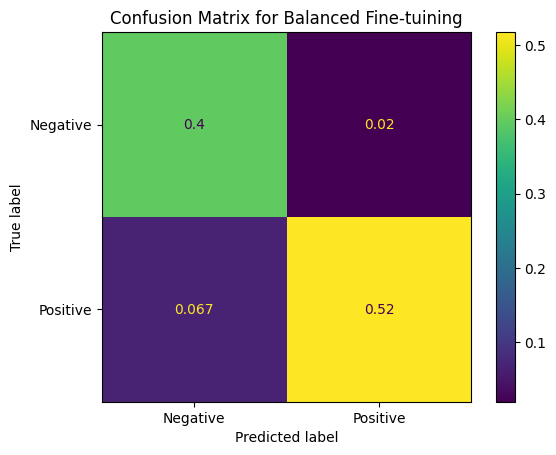

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_true=yelp_test["label"], 
                                        y_pred=yelp_test["predicted"], 
                                        display_labels=["Negative", "Positive"], 
                                        normalize="all"
                                       )
plt.title("Confusion Matrix for Balanced Fine-tuining")
plt.show()

Evidently, the model had better F1 score for the positve case vs the negative. Nevertheless, it is better at picking out the true negatives than picking out the positives. But, there seems to be a worse false detection rate for the negative cases than the positive cases, which brought the F1 score to be lower.

In [11]:
from sklearn.metrics import classification_report

print(classification_report(y_true=yelp_test["label"], 
                            y_pred=yelp_test["predicted"], 
                            target_names=["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.86      0.95      0.90     49369
    Positive       0.96      0.89      0.92     69425

    accuracy                           0.91    118794
   macro avg       0.91      0.92      0.91    118794
weighted avg       0.92      0.91      0.91    118794


The overall accuracy for the model is 91%, while the balanced accuracy is around 92%. Thus, it would seem that this model is not overtly biased towards one class vs another based on all the metrics shown.

In [12]:
compute_accuracy([yelp_test["predicted_scores"], yelp_test["label"]])

{'balanced_accuracy': 0.9185231906822545,
 'roc_auc': 0.9185231906822545,
 'kappa': 0.8235742484967903,
 'f1': 0.9223542124734541}

In [13]:
trainer.save_model()

In [14]:
import gc

try:
    del model
    del trainer
    del results
except NameError:
    pass
gc.collect()
torch.cuda.empty_cache()

## Unbalanced Dataset (But twice as many data points)

Next, an identically structured model is trained on the bigger unbalanced dataset. The goal is to investigate whether the greater number of data points can improve the performance despite not explicitly balancing the labels.

In [15]:
data_dict = {
    "train": "yelp_train_unbalanced.parquet",
    "eval": "yelp_eval.parquet",
    "test": "yelp_test.parquet"
}

yelp_ubatrain_data = load_dataset("parquet", data_files=data_dict, split="train")
yelp_ubatrain_data = yelp_ubatrain_data.filter(lambda x: x["label"] != 3)
yelp_ubatrain_data = yelp_ubatrain_data.map(lambda x: tokenize_and_label(tokenizer, x), 
                                            batched=True)
yelp_ubatrain_data

Map:   0%|          | 0/554372 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 554372
})

The same training setup is used as before.

In [16]:
BATCH_TRAIN = 128
BATCH_EVAL = 256
GRADIENT_STEP = 1
LEARNING_RATE = 1e-4
EPOCHS = 4
LAMBDA = 0.01

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=len(id2label), id2label=id2label, label2id=label2id
).to(device)
for param in model.base_model.parameters():
    param.requires_grad = False


training_args = TrainingArguments(
    output_dir="yelp-distil-bert-subal",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_TRAIN,
    per_device_eval_batch_size=BATCH_EVAL,
    gradient_accumulation_steps=GRADIENT_STEP,
    gradient_checkpointing=False,
    num_train_epochs=EPOCHS,
    weight_decay=LAMBDA,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    seed=SEED
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=yelp_ubatrain_data,
    eval_dataset=yelp_eval_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_accuracy
)

try:
    results = trainer.train(resume_from_checkpoint = True)
except ValueError:
    results = trainer.train(resume_from_checkpoint = False)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Balanced Accuracy,Roc Auc,Kappa,F1
1,0.195800,0.182876,0.924248,0.924248,0.851498,0.939030
2,0.189900,0.177317,0.925914,0.925914,0.855731,0.940979
3,0.188000,0.173726,0.929416,0.929416,0.859607,0.941835
4,0.182600,0.172336,0.928457,0.928457,0.860278,0.942711


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



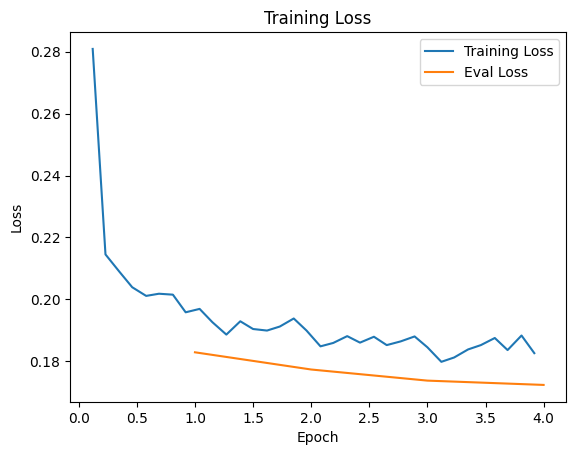

In [17]:
plot_training(trainer)

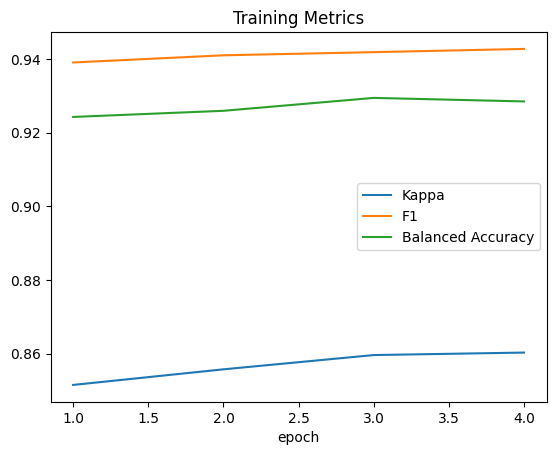

In [18]:
plot_eval(trainer)

In [19]:
yelp_test = load_dataset("parquet", data_files=data_dict, split="test")
yelp_test = yelp_test.filter(lambda x: x["label"] != 3)
yelp_test = test_inference(tokenizer, model, device, yelp_test, BATCH_EVAL)
yelp_test = yelp_test.map(lambda batch: {"label": 1 * np.array(batch["label"]) >= 4}, 
                          batched=True, batch_size=BATCH_EVAL)

Filter:   0%|          | 0/150058 [00:00<?, ? examples/s]

Map:   0%|          | 0/118794 [00:00<?, ? examples/s]

Map:   0%|          | 0/118794 [00:00<?, ? examples/s]

Map:   0%|          | 0/118794 [00:00<?, ? examples/s]

The confusion matrix for the unbalanced model is given below. It performs slightly worse with respect to classifying negatives as positives, but slightly better on classifying positive as negatives.

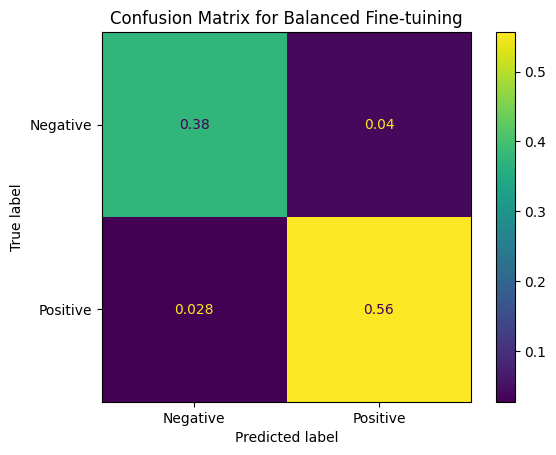

In [20]:
ConfusionMatrixDisplay.from_predictions(y_true=yelp_test["label"], 
                                        y_pred=yelp_test["predicted"], 
                                        display_labels=["Negative", "Positive"], 
                                        normalize="all"
                                       )
plt.title("Confusion Matrix for Balanced Fine-tuining")
plt.show()

Training with more data seems to have lead to a better F1 score as well as overall accuracy on the test set.

In [21]:
print(classification_report(y_true=yelp_test["label"], 
                            y_pred=yelp_test["predicted"], 
                            target_names=["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.93      0.90      0.92     49369
    Positive       0.93      0.95      0.94     69425

    accuracy                           0.93    118794
   macro avg       0.93      0.93      0.93    118794
weighted avg       0.93      0.93      0.93    118794


The balanced accuracy is also slightly higher for the unbalanced model.

In [22]:
compute_accuracy([yelp_test["predicted_scores"], yelp_test["label"]])

{'balanced_accuracy': 0.9278237488906909,
 'roc_auc': 0.9278237488906907,
 'kappa': 0.8591869367376127,
 'f1': 0.9423063212080595}

In [23]:
trainer.save_model()